__Final Models and Evaluations__

__Basic Imports and Dataframe Importing__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import shap
from statistics import mean, stdev
import seaborn as sns
from statannot import add_stat_annotation
from matplotlib.patches import Patch
from dna_features_viewer import GraphicFeature, GraphicRecord

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_curve, RocCurveDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score,roc_auc_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import ConfusionMatrixDisplay

#dataframe importing
reclassified_df = pd.read_csv('austin_db/reclassified_df.csv')
proteinfeatures = pd.read_csv('austin_db/proteinfeatures.csv')
pfam_families = pd.read_csv('Protein_Groupings_TSNE/pfam_families.csv')

__Binary Classifications: Non-Secreted vs Rest & Fully-Secreted vs Rest__

In [3]:
'''
Test the robustness of the machine learning model by perfoming repeated stratified K fold with the random forest model
'''
def RobustnessTest(X_train,y_train):
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    acc = []
    bacc = []
    auc = []
    f1 = []

    for train_index, test_index in skf.split(X_train, y_train):
        x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        rf_model = BalancedRandomForestClassifier()  
        # under sample training data
        rf_model.fit(x_train_fold, y_train_fold)
        y_pred = rf_model.predict(x_test_fold)
        acc.append(accuracy_score(y_test_fold, y_pred))
        bacc.append(balanced_accuracy_score(y_test_fold, y_pred))
        auc.append(roc_auc_score(y_test_fold, y_pred))
        f1.append(f1_score(y_test_fold, y_pred))
    return acc,bacc,auc,f1

Not_Secreted vs Rest y value counts
 0    3938
1    1236
Name: Filtered_Classification, dtype: int64
ACC: 0.7700728434654096 BACC 0.7706692010752925 AUC: 0.8782753447460903 F1: 0.6158950572292319
Fully_Secreted vs Rest y value counts
 0    4280
1     894
Name: Filtered_Classification, dtype: int64
ACC: 0.7501795286690929 BACC 0.7623268277801508 AUC: 0.8829099879914373 F1: 0.519301275107566


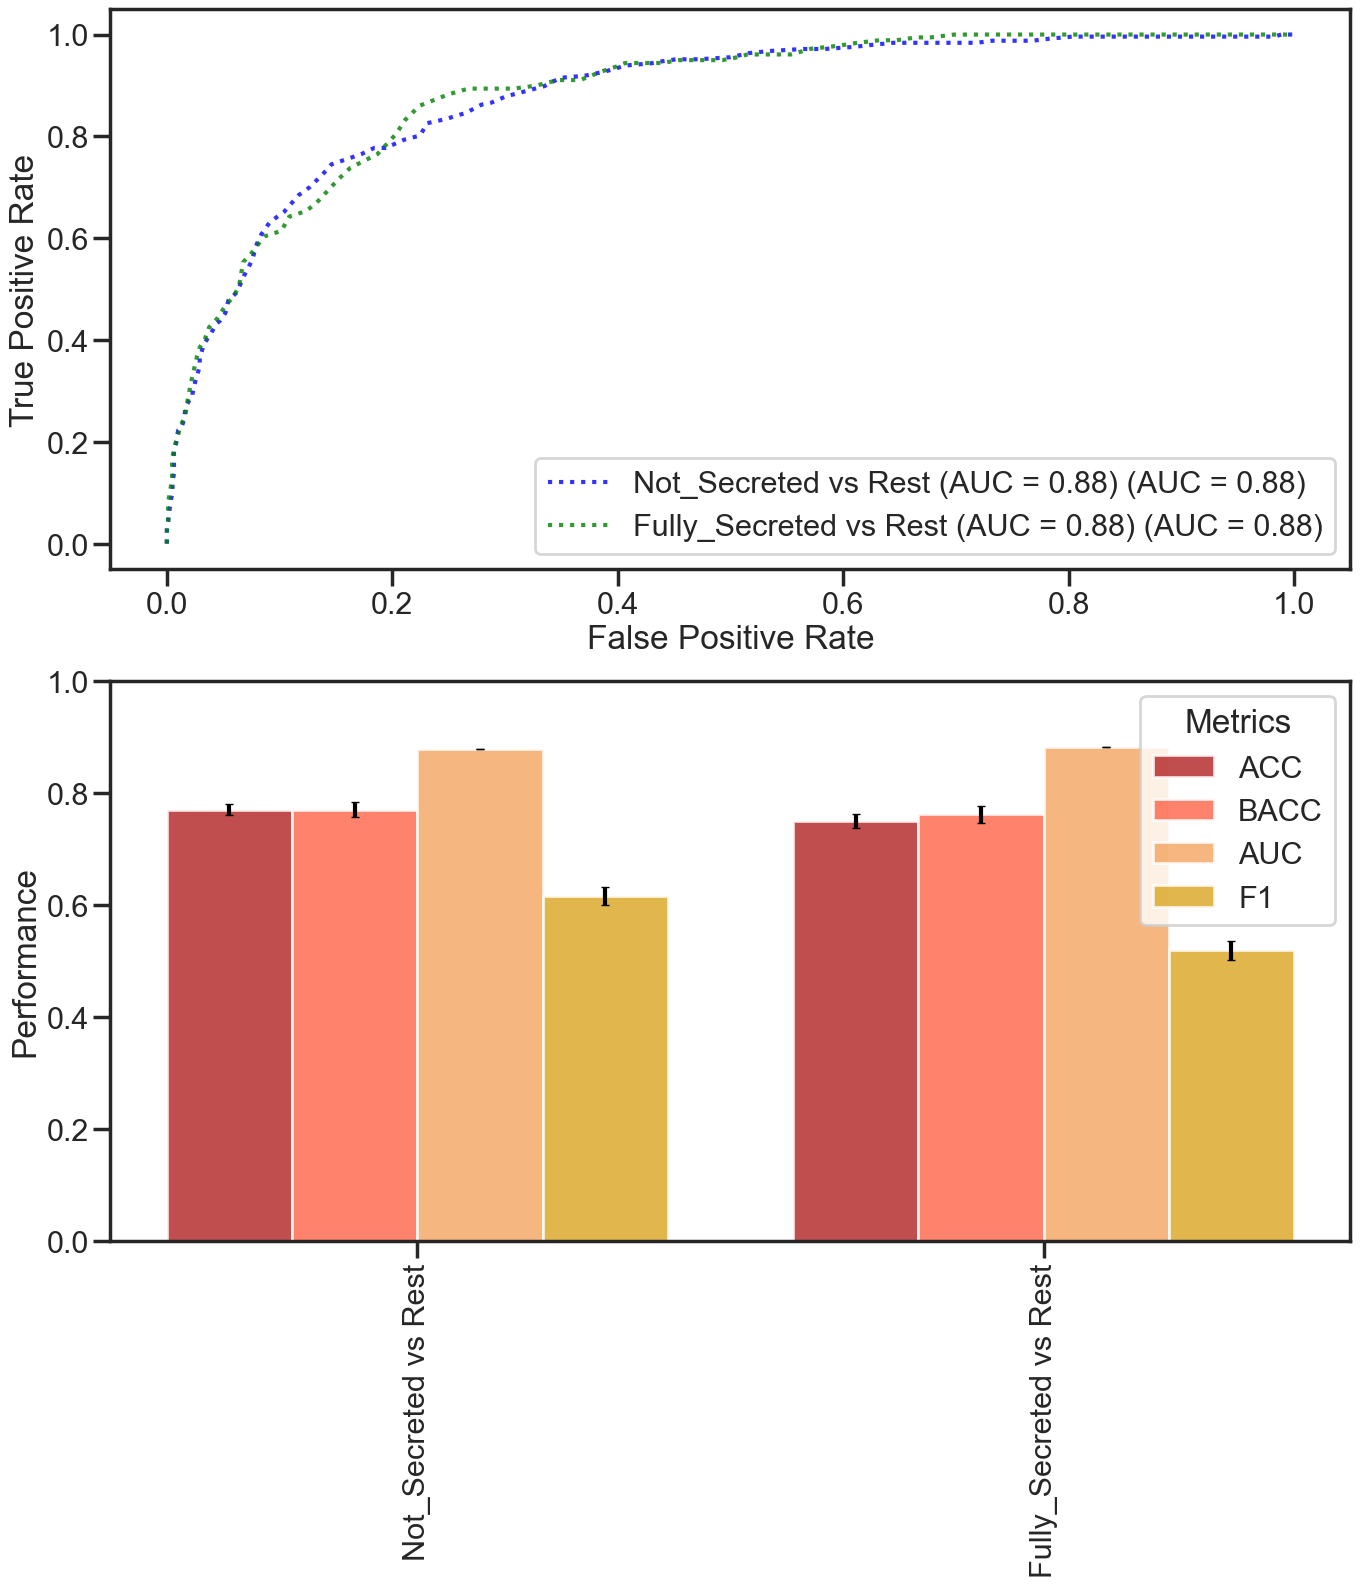

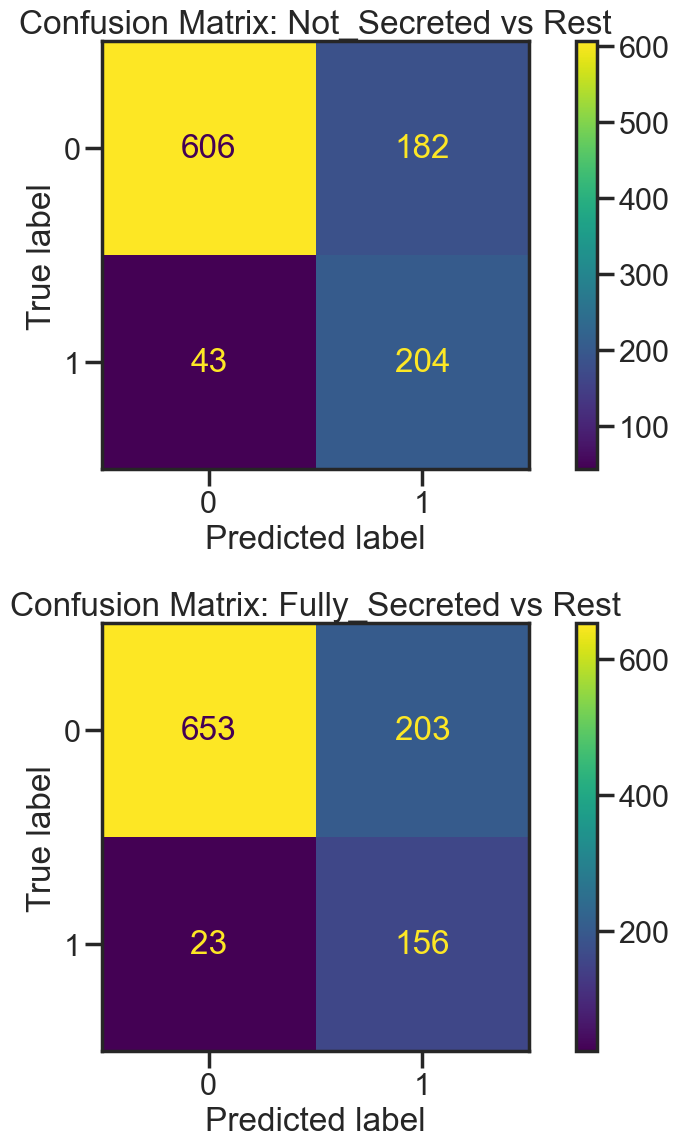

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import numpy as np
from statistics import mean, stdev

sns.set_style("ticks")
sns.set_context("poster")

proteinmodel_results = {}
testlist = {
    'Not_Secreted vs Rest': [{'Not_Secreted': 0, 'Fully_Secreted': 1, 'Partially_Secreted': 1}, 'Filtered_Classification'],
    'Fully_Secreted vs Rest': [{'Not_Secreted': 0, 'Fully_Secreted': 1, 'Partially_Secreted': 0}, 'Filtered_Classification'],
}

fig, ax = plt.subplots(2, 1, figsize=(16, 16))
fig_conf, ax_conf = plt.subplots(len(testlist), 1, figsize=(10, 6 * len(testlist)))  # Figure for confusion matrices

# Colors for the bar plots
colors = {
    'ACC': 'firebrick',
    'BACC': 'tomato',
    'AUC': 'sandybrown',
    'F1': 'goldenrod'
}

# Adjusting labels and layout
bar_width = 0.2

for i, test_name in enumerate(testlist):
    # Changes Classification
    data = reclassified_df.copy()
    data[testlist[test_name][1]] = data[testlist[test_name][1]].map(testlist[test_name][0])
    data = data[data[testlist[test_name][1]] != 2]
    data = data.mask(data[testlist[test_name][1]].eq('None')).dropna()

    # Create X and Y
    X = data.drop(['CSF', 'Uniprot', 'Filtered_Classification', 'Sequence'], axis=1)
    y = data[testlist[test_name][1]]
    print(test_name, 'y value counts\n', y.value_counts())
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Create models
    rf_model = BalancedRandomForestClassifier(random_state=42)

    # Test for robustness on training split
    acc, bacc, auc_train, f1 = RobustnessTest(X_train, y_train)

    # Tests model on test split after training
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_test = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC for the test set
    proteinmodel_results.update({test_name: [acc, bacc, auc_test, f1]})

    # Plot ROC curve
    if 'MvsBO' in test_name:
        colour = 'orange'
    elif 'Not_Secreted vs Rest' in test_name:
        colour = 'b'
    elif 'MvsCSF' in test_name:
        colour = 'cyan'
    else:
        colour = 'g'
    if 'STR' in test_name:
        ls = 'dashed'
    elif '_S' in test_name:
        ls = 'dotted'
    else:
        ls = 'solid'

    RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax[0], alpha=0.8, color=colour, linestyle=ls, name=f"{test_name} (AUC = {auc_test:.2f})")

    # Update bar plot with the calculated AUC for the test set
    acc_stdev = float(stdev(acc)) if len(acc) > 1 else 0
    bacc_stdev = float(stdev(bacc)) if len(bacc) > 1 else 0
    auc_stdev = float(stdev([auc_test])) if len([auc_test]) > 1 else 0
    f1_stdev = float(stdev(f1)) if len(f1) > 1 else 0

    ax[1].bar(i - bar_width * 1.5, float(mean(acc)), yerr=acc_stdev, align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['ACC'], label='ACC' if i == 0 else "")
    ax[1].bar(i - bar_width * 0.5, float(mean(bacc)), yerr=bacc_stdev, align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['BACC'], label='BACC' if i == 0 else "")
    ax[1].bar(i + bar_width * 0.5, float(auc_test), yerr=auc_stdev, align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['AUC'], label='AUC' if i == 0 else "")
    ax[1].bar(i + bar_width * 1.5, float(mean(f1)), yerr=f1_stdev, align='center', alpha=0.8, ecolor='black', capsize=3, width=bar_width, color=colors['F1'], label='F1' if i == 0 else "")
    print('ACC:', float(mean(acc)), 'BACC', float(mean(bacc)), 'AUC:', float(auc_test), 'F1:', float(mean(f1)))

    # Plot confusion matrix (new)
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=rf_model.classes_).plot(ax=ax_conf[i])
    ax_conf[i].set_title(f'Confusion Matrix: {test_name}')

# Adjust the ticks and labels
ax[1].set_xticks(np.arange(len(testlist)))
ax[1].set_xticklabels(testlist.keys())
ax[0].set_xlabel('False Positive Rate', fontsize=24)
ax[0].set_ylabel('True Positive Rate', fontsize=24)
ax[1].set_ylabel('Performance', fontsize=24)
ax[1].legend(title='Metrics')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylim([0, 1])

# Save the graphs and display
plt.tight_layout()
plt.show()

fig.savefig('final_figures/Two_Class_Final.png', dpi=300, bbox_inches="tight")
fig_conf.savefig('final_figures/Two_Class_Final_Confusion_Matrices.png', dpi=300, bbox_inches="tight")



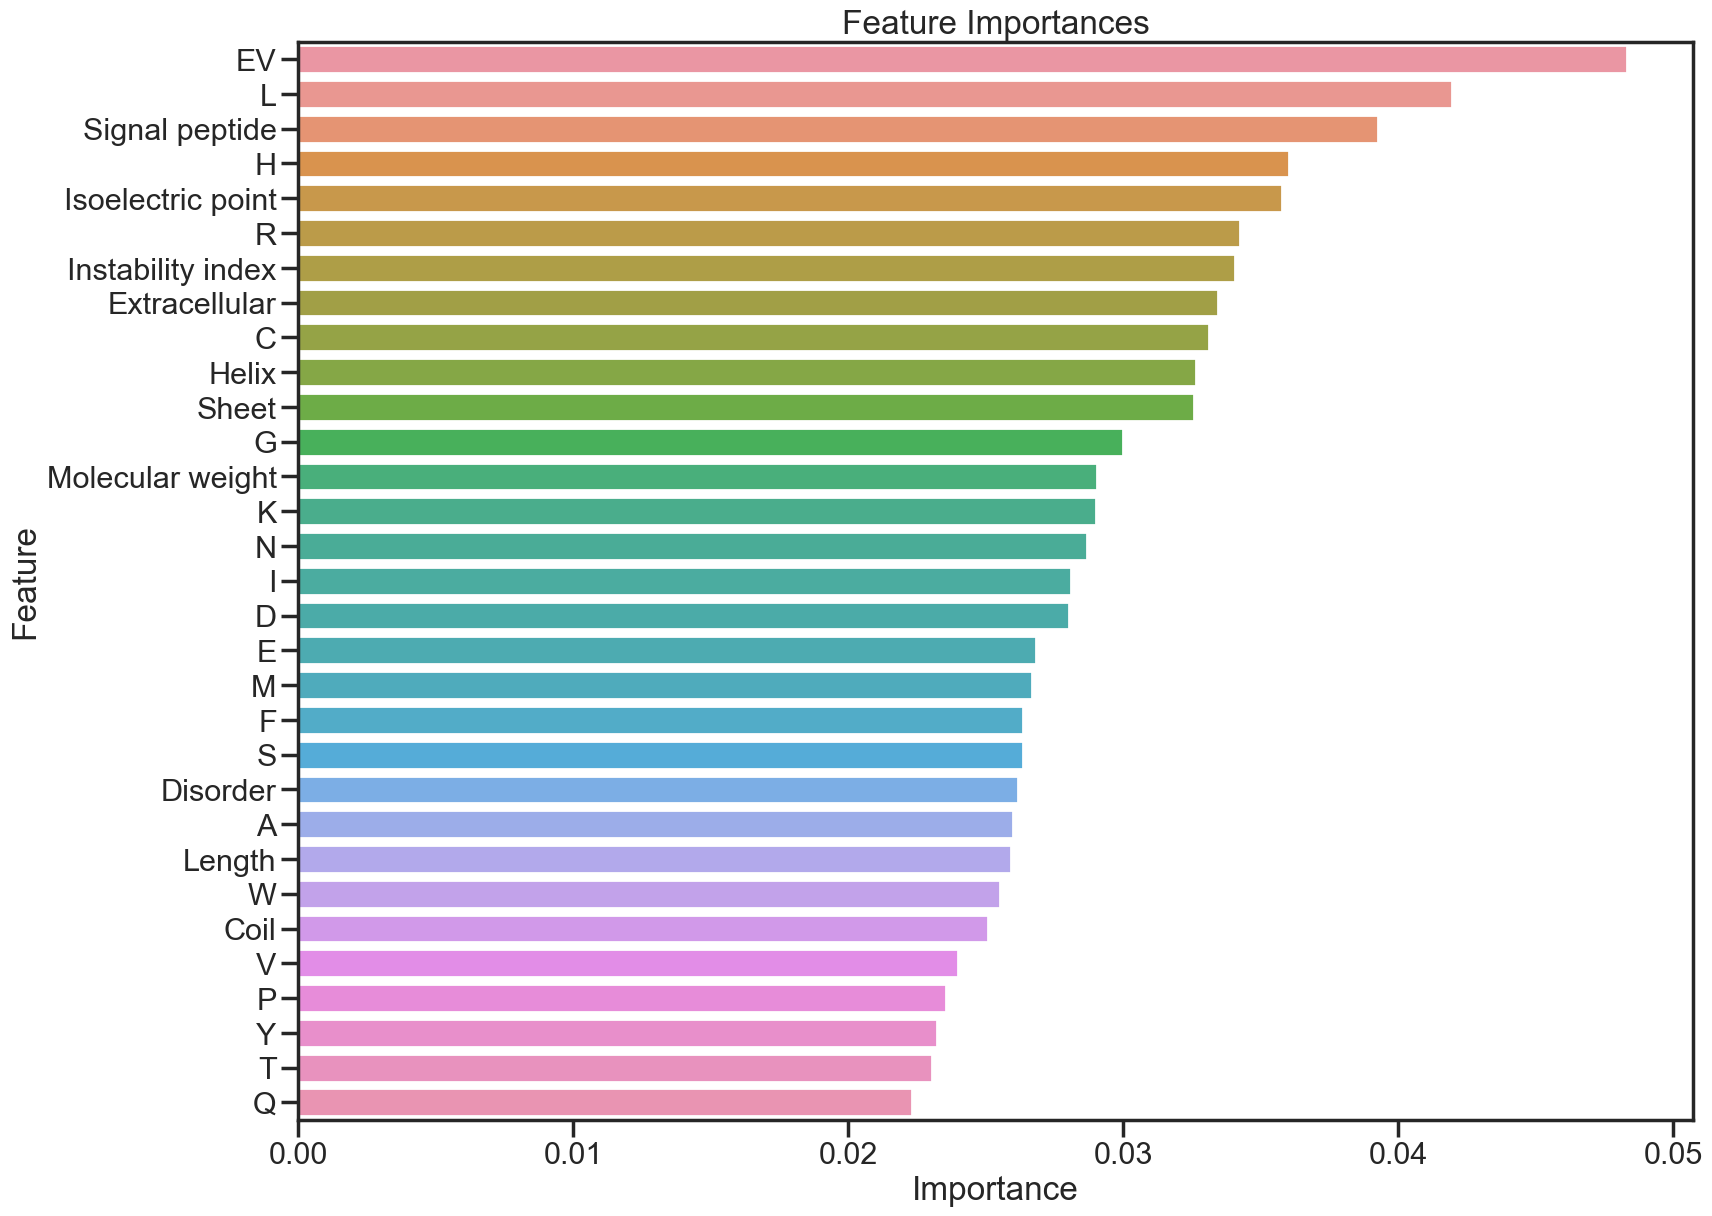

Values above the average:
['EV', 'L', 'Signal peptide', 'H', 'Isoelectric point', 'R', 'Instability index', 'Extracellular', 'C', 'Helix', 'Sheet', 'G', 'Molecular weight', 'K', 'N', 'I', 'D', 'E', 'M', 'F', 'S', 'Disorder', 'A', 'Length', 'W', 'Coil', 'V', 'P', 'Y', 'T', 'Q']


In [5]:
#Gathering Feautes of Above Average Importance
rf_feature_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})
average_value = rf_importance_df['Importance'].mean()
above_average_values = rf_importance_df[rf_importance_df['Importance'] > average_value]

# Sort the dataframe by importance
above_average_values = above_average_values.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(18, 14))
sns.barplot(x='Importance', y='Feature', data=above_average_values)
plt.title('Feature Importances')
plt.savefig('final_figures/Two_Class_Final_Features.png', dpi=300, bbox_inches="tight")
plt.show()



print("Values above the average:")
print(above_average_values['Feature'].tolist())

__Three Class Random Forest__

                    precision    recall  f1-score   support

    Fully_Secreted       0.42      0.70      0.52       179
      Not_Secreted       0.93      0.69      0.79       788
Partially_Secreted       0.30      0.66      0.41        68

          accuracy                           0.69      1035
         macro avg       0.55      0.68      0.58      1035
      weighted avg       0.80      0.69      0.72      1035

Test F1 Score: 0.72


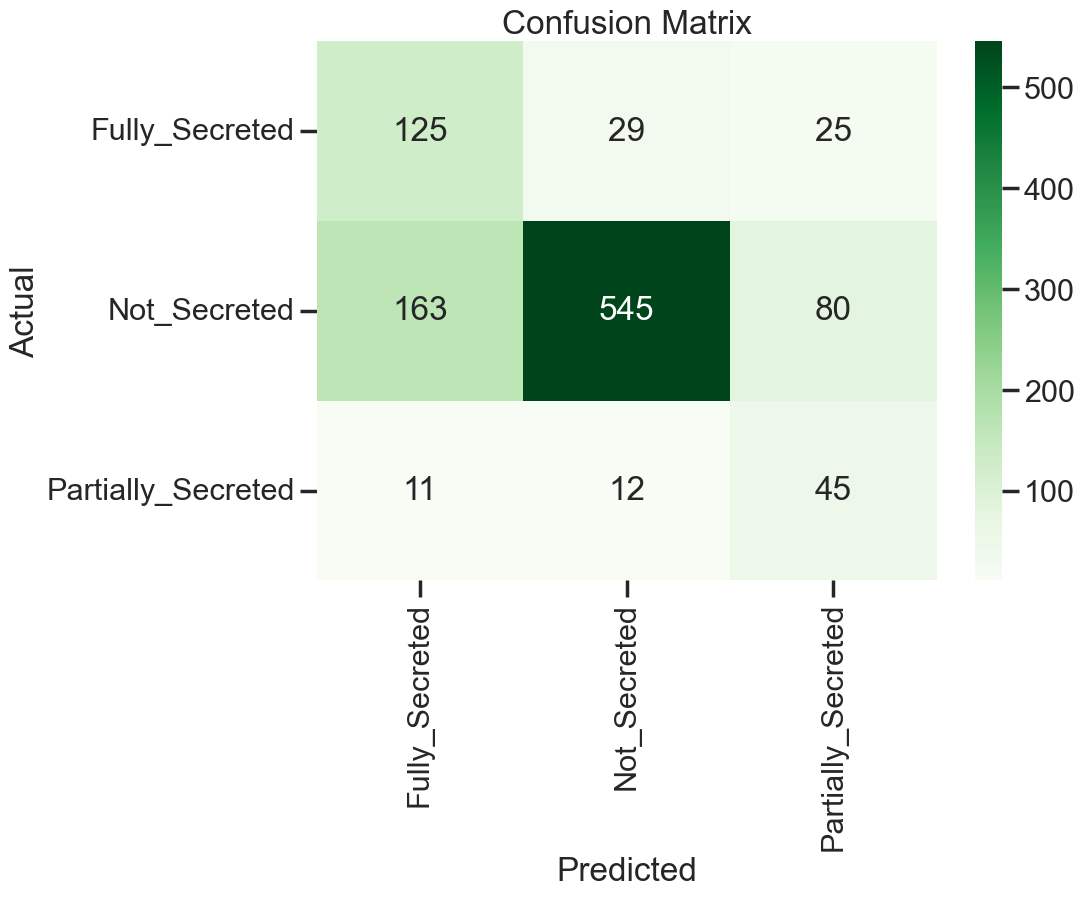

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

data = reclassified_df.copy()

# create X and Y 
X = data.drop(['CSF', 'Uniprot','Filtered_Classification','Sequence'], axis=1)
y = data['Filtered_Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Create a RandomForestClassifier
rf_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_pred, average='weighted')
print(f'Test F1 Score: {f1_test:.2f}')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

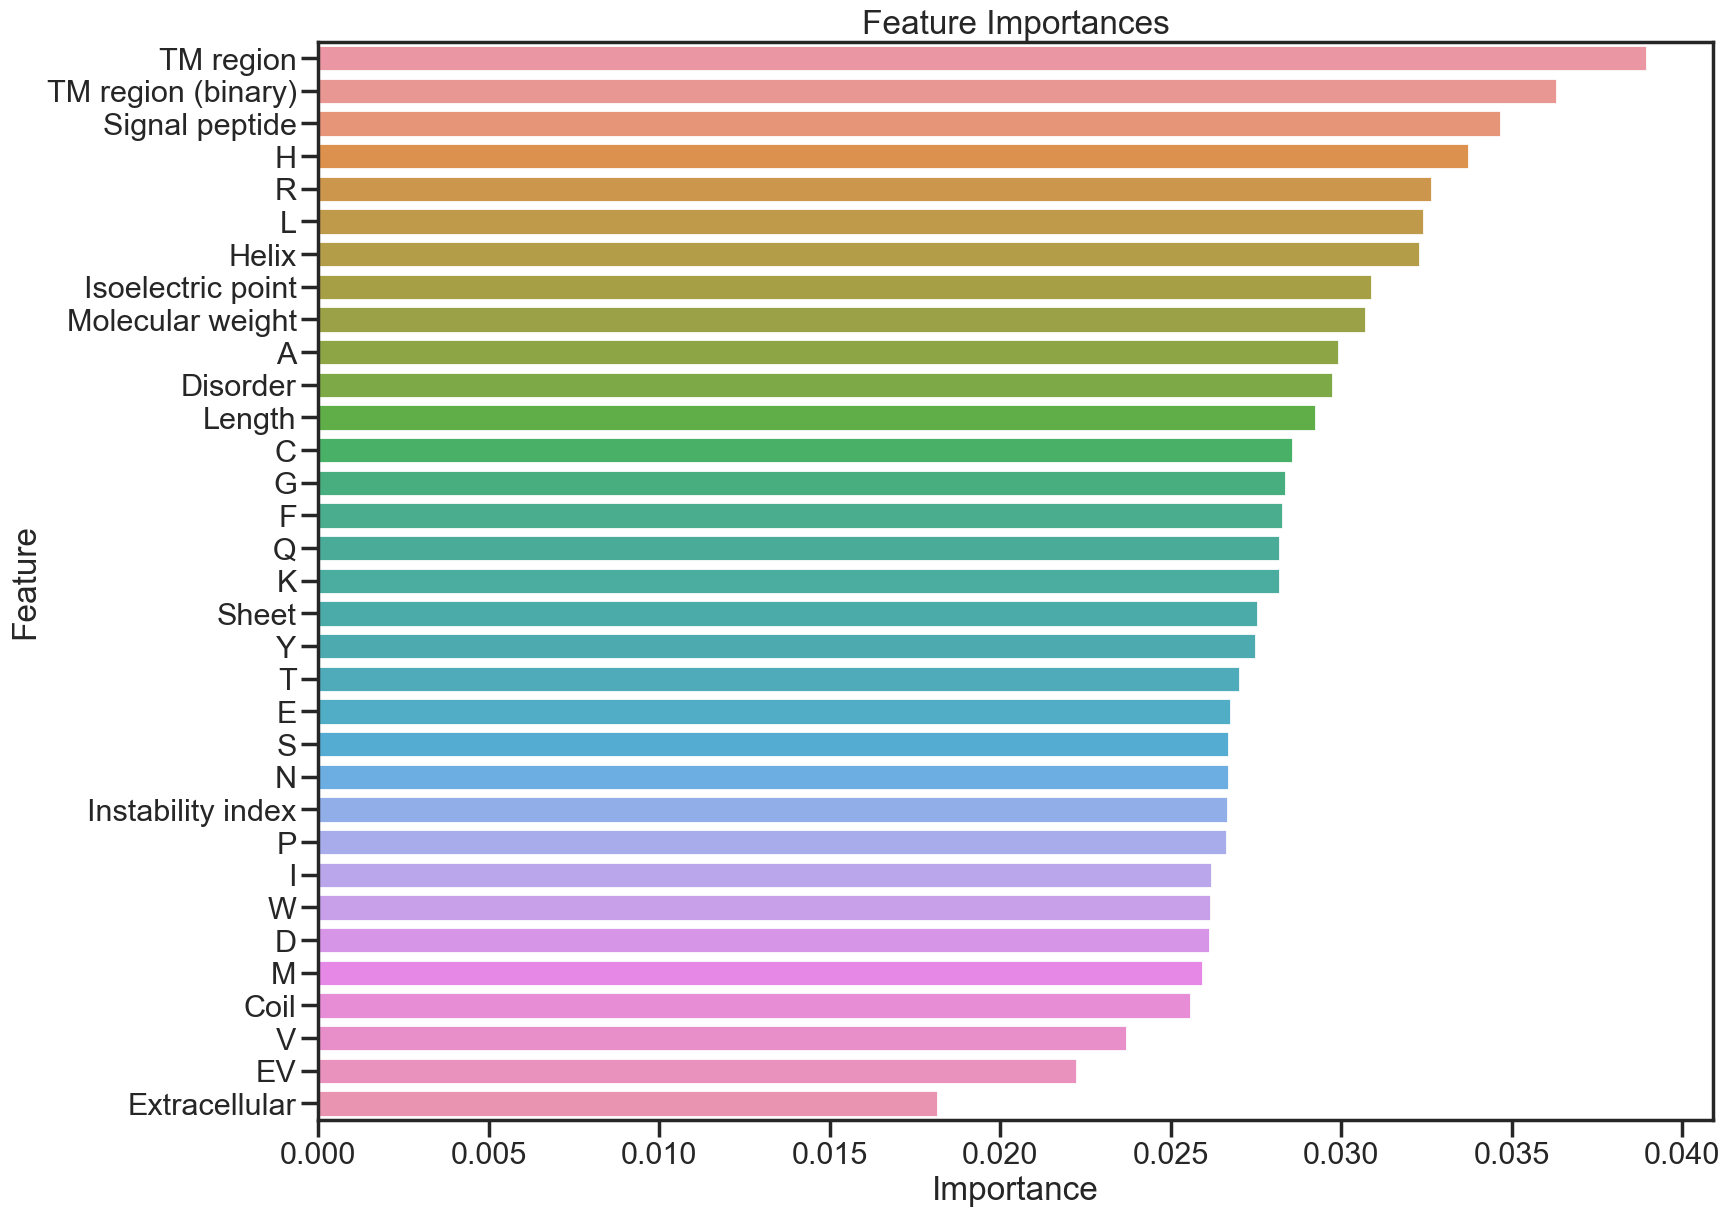

Values above the average:
['TM region', 'TM region (binary)', 'Signal peptide', 'H', 'R', 'L', 'Helix', 'Isoelectric point', 'Molecular weight', 'A', 'Disorder', 'Length', 'C', 'G', 'F', 'Q', 'K', 'Sheet', 'Y', 'T', 'E', 'S', 'N', 'Instability index', 'P', 'I', 'W', 'D', 'M', 'Coil', 'V', 'EV', 'Extracellular']


In [24]:
#Gathering Feautes of Above Average Importance
rf_feature_importances = rf_classifier.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})
average_value = rf_importance_df['Importance'].mean()
above_average_values = rf_importance_df[rf_importance_df['Importance'] > average_value]

# Sort the dataframe by importance
above_average_values = above_average_values.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(18, 14))
sns.barplot(x='Importance', y='Feature', data=above_average_values)
plt.title('Feature Importances')
plt.savefig('final_figures/Three_Class_RF_Features.png', dpi=300, bbox_inches="tight")
plt.show()

print("Values above the average:")
print(above_average_values['Feature'].tolist())

__Three Class Gradient Boosting Machine__

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

df = reclassified_df.copy()

# create X and Y 
X = df.drop(['CSF', 'Uniprot','Filtered_Classification','Sequence'], axis=1)
y = df['Filtered_Classification']


# Encode the target variable
y_encoded, class_names = pd.factorize(y)

# Training/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the model with class weights
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# K-Folds cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get predictions
y_pred = cross_val_predict(model, X_train_resampled, y_train_resampled, cv=kf)

# Calculate F1 score
f1 = f1_score(y_train_resampled, y_pred, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_train_resampled, y_pred, target_names=class_names))

# Train on full training data and evaluate on test data
model.fit(X_train_resampled, y_train_resampled)
y_test_pred = model.predict(X_test)

# Calculate F1 score for test set
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {f1_test:.2f}')

# Print classification report for test set
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

[21:26:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:26:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:26:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:26:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



F1 Score: 0.92
Classification Report:
                    precision    recall  f1-score   support

      Not_Secreted       0.90      0.90      0.90      3150
    Fully_Secreted       0.92      0.89      0.90      3150
Partially_Secreted       0.94      0.96      0.95      3150

          accuracy                           0.92      9450
         macro avg       0.92      0.92      0.92      9450
      weighted avg       0.92      0.92      0.92      9450



[21:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Test F1 Score: 0.78
Test Classification Report:
                    precision    recall  f1-score   support

      Not_Secreted       0.85      0.91      0.88       788
    Fully_Secreted       0.60      0.42      0.50       179
Partially_Secreted       0.37      0.32      0.34        68

          accuracy                           0.79      1035
         macro avg       0.61      0.55      0.57      1035
      weighted avg       0.77      0.79      0.78      1035



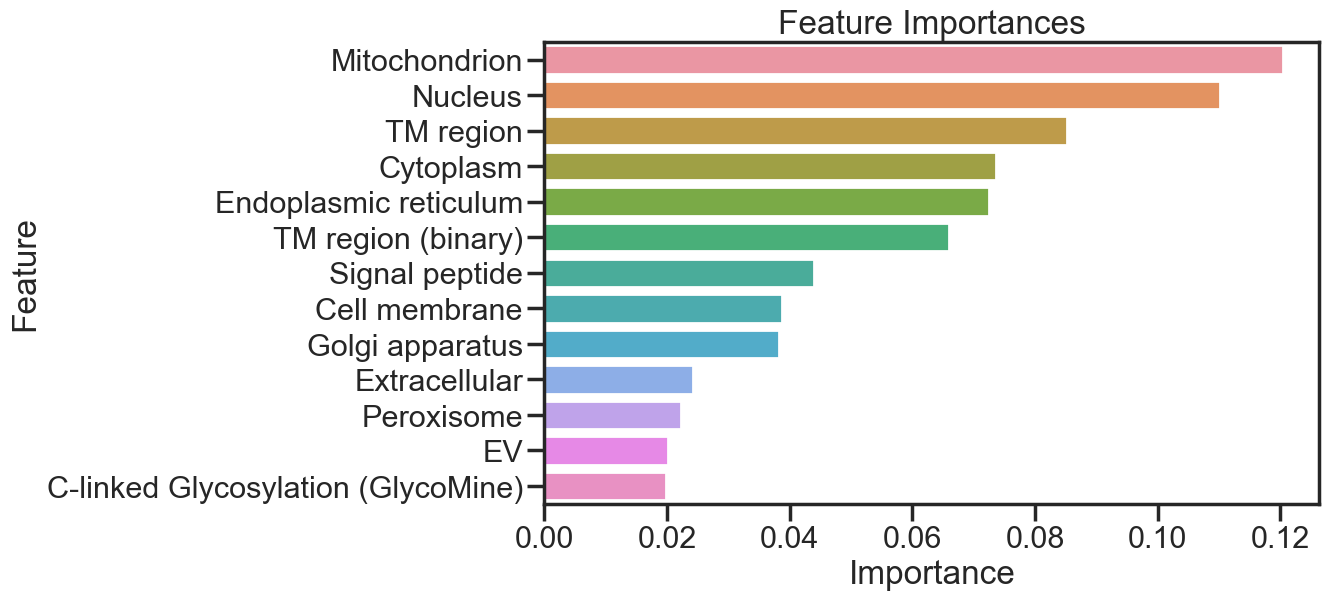

In [29]:
# Get and plot feature importances
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
average_value = importance_df['Importance'].mean()
above_average_values = importance_df[importance_df['Importance'] > average_value]

# Sort the dataframe by importance
above_average_values = above_average_values.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=above_average_values)
plt.title('Feature Importances')
plt.savefig('final_figures/Three_Class_XGB_Features.png', dpi=300, bbox_inches="tight")
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5174 samples in 0.005s...
[t-SNE] Computed neighbors for 5174 samples in 0.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5174
[t-SNE] Computed conditional probabilities for sample 2000 / 5174
[t-SNE] Computed conditional probabilities for sample 3000 / 5174
[t-SNE] Computed conditional probabilities for sample 4000 / 5174
[t-SNE] Computed conditional probabilities for sample 5000 / 5174
[t-SNE] Computed conditional probabilities for sample 5174 / 5174
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.245827
[t-SNE] KL divergence after 3000 iterations: 0.193992


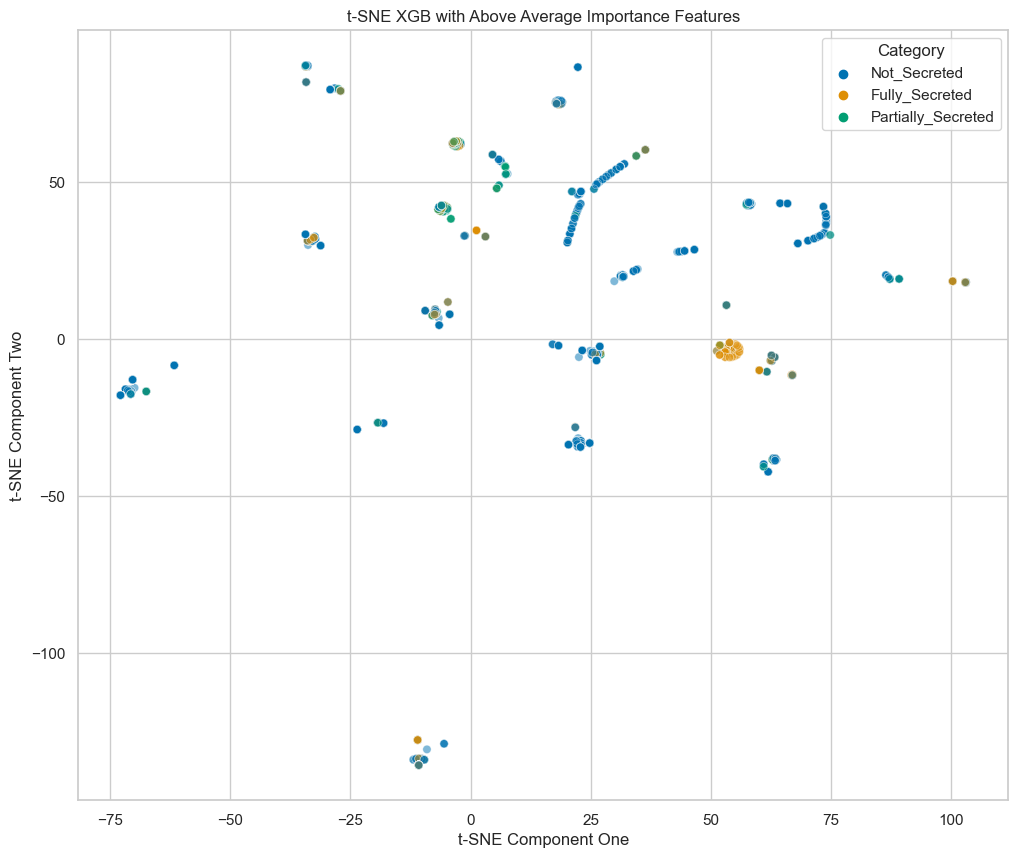

In [35]:
#TSNE with the XGB

features = reclassified_df[above_average_values['Feature']]
labels = reclassified_df['Filtered_Classification']
features_scaled = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000,random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

tsne_df = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['Category'] = labels

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=tsne_df,
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Category',
    palette='colorblind',  # Choose a color palette
    alpha = 0.5
)

# Set labels and title
plt.xlabel('t-SNE Component One')
plt.ylabel('t-SNE Component Two')
plt.title('t-SNE XGB with Above Average Importance Features')

plt.savefig('final_figures/TSNE_Above_Average_Importance_Features_XGB.png',dpi=300, bbox_inches = "tight")

plt.show()

__Multilayer Perceptron__

Test F1 Score: 0.66
Test Classification Report:
                    precision    recall  f1-score   support

      Not_Secreted       0.91      0.61      0.74       788
    Fully_Secreted       0.38      0.62      0.47       179
Partially_Secreted       0.17      0.54      0.26        68

          accuracy                           0.61      1035
         macro avg       0.49      0.59      0.49      1035
      weighted avg       0.77      0.61      0.66      1035



Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.


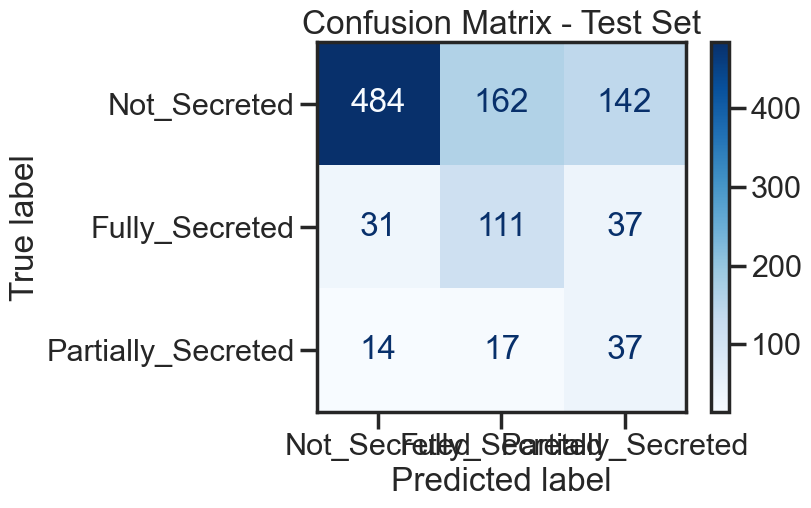

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

df = reclassified_df.copy()

# create X and Y 
X = df.drop(['CSF', 'Uniprot','Filtered_Classification','Sequence'], axis=1)
y = df['Filtered_Classification']

# Encode the target variable
y_encoded, class_names = pd.factorize(y)

# Training/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Handle class imbalance using undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Normalize the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Initialize the MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(40, 20), max_iter=300, random_state=42)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_test_pred = model.predict(X_test)

# Calculate F1 score for the test set
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print(f'Test F1 Score: {f1_test:.2f}')

# Print classification report for the test set
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Plot confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

# Compute feature importances using permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

**Brief Exploration into Important Features from XGB**

In [5]:
mito_df = reclassified_df[reclassified_df['Mitochondrion'] == 1]
print('Mitochondrial Proteins Secretion Level:', mito_df['Filtered_Classification'].value_counts())

nucl_df = reclassified_df[reclassified_df['Nucleus'] == 1]
print('Nucleus Proteins Secretion Level:', nucl_df['Filtered_Classification'].value_counts())

cyto_df = reclassified_df[reclassified_df['Cytoplasm'] == 1]
print('Cytoplasm Proteins Secretion Level:', cyto_df['Filtered_Classification'].value_counts())

Mitochondrial Proteins Secretion Level: Not_Secreted          665
Fully_Secreted         49
Partially_Secreted     23
Name: Filtered_Classification, dtype: int64
Nucleus Proteins Secretion Level: Not_Secreted          721
Fully_Secreted        117
Partially_Secreted     37
Name: Filtered_Classification, dtype: int64
Cytoplasm Proteins Secretion Level: Not_Secreted          1715
Fully_Secreted         362
Partially_Secreted      61
Name: Filtered_Classification, dtype: int64
